# Data Exploration

In [1]:
import pandas as pd
import numpy as np

In [2]:
csv_path = 'data/btc_usd_weekly.csv'

In [3]:
df = pd.read_csv(csv_path)

In [4]:
# remove 1 nan row and column adj close
df = df.dropna().reset_index(drop=True)
df = df.drop('Adj Close', axis=1)

## Compute metrics

### Compute Percentual change

In [5]:
df['Change'] = (df['Close'] - df['Open'])
df['Percentual Change'] = (df['Change'] / df['Open']) * 100

### Compute Variation
The price difference from the previous day

In [6]:
def calculate_variation(df: pd.DataFrame):
    variation_lst = []
    variation = 0
    for row in df.iterrows():
        if row[0] == 0:
            pass
        else:
            # print(row[0])
            variation = df.iloc[row[0]]['Change'] - df.iloc[row[0]-1]['Change']
        variation_lst.append(variation)
    return variation_lst

In [7]:
variations_lst = calculate_variation(df)
variations = pd.Series(variations_lst, name='Variation')
df = pd.concat([df, variations], axis=1)

### Compute RSI

In [8]:
def calculate_rsi(df: pd.DataFrame):
    # Based on https://www.investopedia.com/terms/r/rsi.asp
    rsi_lst = []
    for row in df.iterrows():
        if row[0] < 14:
            rsi = 0
        else:
            up = []
            down = []
            for i in range(row[0] - 14, row[0]):
                if df.iloc[i]['Percentual Change'] > 0:
                    up.append(df.iloc[i]['Percentual Change'])
                else:
                    down.append(df.iloc[i]['Percentual Change'])
            up_mean = np.mean(up) / 14
            down_mean = np.mean(down) / 14

            rs = np.abs(up_mean / down_mean)
            rsi = 100 - (100/(1 + rs))
            
        rsi_lst.append(rsi)
    return rsi_lst

In [9]:
rsi_lst = calculate_rsi(df)
rsi = pd.Series(rsi_lst, name='RSI')
df = pd.concat([df, rsi], axis=1)    

In [10]:
df[14:20]

,Date,Open,High,Low,Close,Volume,Change,Percentual Change,Variation,RSI
14,2015-04-27,219.429001,243.240005,218.022995,240.358002,162643200.0,20.929001,9.537938,24.111008,54.432408
15,2015-05-04,240.356003,247.804001,228.572998,240.296005,166059200.0,-0.059998,-0.024962,-20.988999,48.928614
16,2015-05-11,240.298996,244.270004,234.057007,236.802002,130322100.0,-3.496994,-1.455268,-3.436996,55.800022
17,2015-05-18,236.886993,241.977997,231.817001,240.953003,114746500.0,4.066010,1.716434,7.563004,55.729553
18,2015-05-25,240.927002,241.020996,229.542007,230.190002,107149900.0,-10.737000,-4.456537,-14.803010,53.651177
19,2015-06-01,230.233002,231.712997,221.296005,222.880997,121536400.0,-7.352005,-3.193289,3.384995,57.364295


## Decide label
Indicate to buy if the variance of the next week is higher than 1

In [177]:
def decide_buy(df: pd.DataFrame):
    # 0: no buy
    # 1: buy
    buy_lst = []
    for row in df.iterrows():
        if row[0] == len(df)-1:
            buy = 0
        else:
            if df.iloc[row[0]+1]['Percentual Change'] > 10:
                buy = 1
            else:
                buy = 0
        buy_lst.append(buy)
    return buy_lst

In [178]:
# df_labeled.drop('Buy', axis=1)

In [179]:
buy_lst = decide_buy(df)
buy_lst = pd.Series(buy_lst, name='Buy')
df_labeled = pd.concat([df, buy_lst], axis=1)

In [180]:
df_labeled.head()

,Date,Open,High,Low,Close,Volume,Change,Percentual Change,Variation,RSI,Buy
0,2015-01-19,211.470993,255.074005,205.153000,253.718002,189165500.0,42.247009,19.977685,0.000000,0.0,0
1,2015-01-26,254.078995,309.384003,212.014999,226.972000,306840500.0,-27.106995,-10.668727,-69.354004,0.0,0
2,2015-02-02,226.490997,245.957001,214.725006,223.412003,183691200.0,-3.078994,-1.359433,24.028001,0.0,0
3,2015-02-09,223.389008,265.610992,215.332001,234.824997,230343800.0,11.435989,5.119316,14.514983,0.0,0
4,2015-02-16,234.824997,255.320007,229.022003,235.977005,154676000.0,1.152008,0.490582,-10.283981,0.0,1


In [181]:
df_labeled['Buy'].value_counts()

Buy
0    378
1     75
Name: count, dtype: int64

In [32]:
df['Percentual Change'].describe()

count    453.000000
mean       1.569781
std       10.053202
min      -33.519695
25%       -3.132637
50%        1.228530
75%        6.167344
max       41.279709
Name: Percentual Change, dtype: float64

In [6]:
# def decide_label(row):
#     label = 0
#     if row['Percentual Change'] > 0.5:
#         label = 1
#     return label

In [7]:
# df['Buy'] = df.apply(decide_label, axis=1) 

## Data Analysis

In [182]:
features = df_labeled.drop(['Buy', 'Date'], axis=1)
labels = df_labeled.loc[:,'Buy']

In [183]:
features_selected = features.loc[14:, ['RSI', 'Volume']]

In [187]:
features_selected = features_selected.loc[features_selected['Volume'] > 1e11]
labels_selected = labels.loc[features_selected.index]

In [185]:
import matplotlib.pyplot as plt

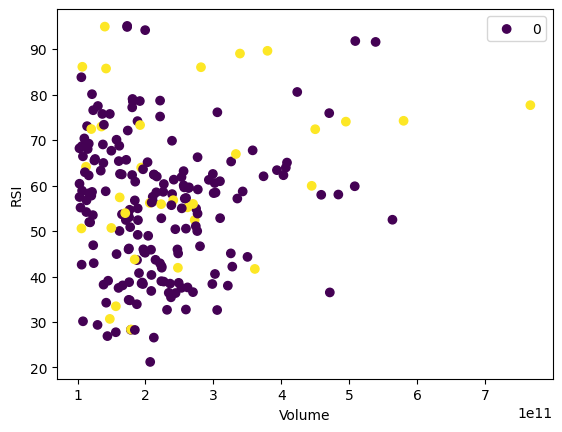

In [188]:
plt.scatter(features_selected['Volume'], features_selected['RSI'], c=labels_selected)
plt.xlabel('Volume')
plt.ylabel('RSI')
plt.legend(labels[14:])
plt.show()

In [44]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [112]:
X_train, X_test, y_train, y_test = train_test_split(features_selected, labels_selected)

In [65]:
# parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10]}
# clf = GridSearchCV(svc, parameters)
# clf.fit(features[14:], c)

### SCV

In [113]:
svc = SVC()

In [114]:
svc.fit(X_train, y_train)

SVC()

In [115]:
svc.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [116]:
score = svc.score(X_test, y_test)
score

0.4909090909090909

### Linear Regression

In [117]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
score = lr.score(X_test, y_test)
print(score)

-0.1262047955576031


In [118]:
lr.coef_

array([2.92277617e-04, 8.23863683e-13])

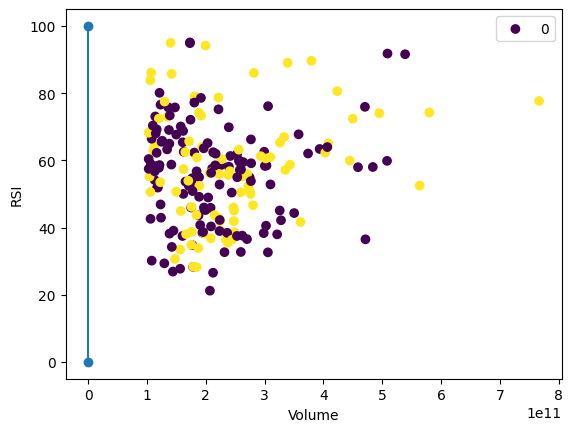

In [120]:
plt.scatter(features_selected['Volume'], features_selected['RSI'], c=labels_selected)
plt.xlabel('Volume')
plt.ylabel('RSI')
plt.legend(labels[14:])
plt.plot([0, lr.coef_[1]], [100, 100*lr.coef_[0] + lr.coef_[1]], marker='o')
plt.show()

### Logistic Regression

In [121]:
logreg = LogisticRegression(C=0.01)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
score = logreg.score(X_test, y_test)
print(score)

0.4909090909090909


In [122]:
logreg.coef_

array([[-1.29338905e-21, -1.44015710e-12]])

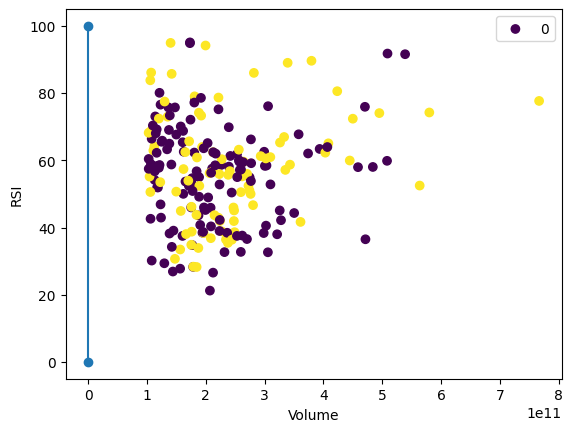

In [124]:
plt.scatter(features_selected['Volume'], features_selected['RSI'], c=labels_selected)
plt.xlabel('Volume')
plt.ylabel('RSI')
plt.legend(labels[14:])
plt.plot([0, logreg.coef_[0][1]], [100, 100*logreg.coef_[0][0] + logreg.coef_[0][1]], marker='o')
plt.show()

### Decision Tree

In [125]:
from sklearn.tree import DecisionTreeClassifier

In [158]:
dt = DecisionTreeClassifier(max_depth=12)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [159]:
score = dt.score(X_test, y_test)
score

0.509090909090909